<H1>Red Hat NLP Spark Project</H1>

This notebook uses Red Hat's OpenShift data logs and processes them using Drain3. 

The first thing this notebook does is webscrape the OpenShift logs and installs dependencies. After, the logs are then cleaned by removing leading tags, dates, timestamps and other unique identifiers. This is done manually because drain does not do this consistently for all logs. Finally the parsed logs are then fed into Drain3 and then put into a dictionary sorted by cluster ID.

The final step that needs to be done is to sift out the pass and fail logs based on their cluster ID and visualize our data.

In [38]:
!pip3 install drain3
!pip3 install kafka-python
!pip3 install redis

<H3>Web scraping</H3>

Gathers OpenShift using BeautifulSoup and then returns an array containing all of the logs.

In [39]:
# Web scraping (Kyle, due 02/26/2021)
#     BeautifulSoup for web scraping

from urllib.request import urlopen
from bs4 import BeautifulSoup
from google.colab import files
import pandas as pd
import io
import numpy as np
import dateutil
from dateutil import parser
import textblob
import requests
import matplotlib.pyplot as plt
import json

#url core needed to pull
website = "https://gcsweb-ci.apps.ci.l2s4.p1.openshiftapps.com"
base = "https://gcsweb-ci.apps.ci.l2s4.p1.openshiftapps.com/gcs/origin-ci-test/logs/canary-release-openshift-origin-installer-e2e-aws-4.5-cnv/"
ending = "build-log.txt"
finished = "finished.json"
url = "https://gcsweb-ci.apps.ci.l2s4.p1.openshiftapps.com/gcs/origin-ci-test/logs/canary-release-openshift-origin-installer-e2e-aws-4.5-cnv/1300557127638585344/build-log.txt"
page = requests.get(base)   
data = page.text
soup = BeautifulSoup(data)
links = []
for link in soup.find_all('a'):
    links.append(link.get('href'))
links = links[1:-1]

final_array = []
labels_link = []
# create array of urls
for x in range(len(links)):
  final_array.append(str(website) + str(links[x]) + str(ending))
  labels_link.append(str(website) + str(links[x]) + str(finished))

# pull all urls logs and store in 2-d array where array_of_logs[x] is a build-log file and 
# array_of_logs[x][y] is an individual log line split by new line
array_of_logs = []
for x in range(len(final_array)):
  page = urlopen(final_array[x])
  html_bytes = page.read()
  array_of_logs.append(str(html_bytes).split('\\n'))
  
# first log
# print(len(lab))


In [40]:
#url core needed to pull
website2 = "https://gcsweb-ci.apps.ci.l2s4.p1.openshiftapps.com"
base2 = "https://gcsweb-ci.apps.ci.l2s4.p1.openshiftapps.com/gcs/origin-ci-test/logs/release-openshift-ocp-installer-e2e-aws-serial-4.1/"
ending2 = "build-log.txt"
finished2 = "finished.json"
page2 = requests.get(base2)    
data2 = page2.text
soup2 = BeautifulSoup(data2)
links2 = []
for link2 in soup2.find_all('a'):
    links2.append(link2.get('href'))
links2 = links2[1:-1]

final_array2 = []
labels_link2 = []
# create array of urls
for x in range(len(links2)):
  final_array2.append(str(website2) + str(links2[x]) + str(ending2))
  labels_link2.append(str(website2) + str(links2[x]) + str(finished2))

# pull all urls logs and store in 2-d array where array_of_logs[x] is a build-log file and 
# array_of_logs[x][y] is an individual log line split by new line
array_of_logs2 = []
for x in range(len(final_array2)):
  page2 = urlopen(final_array2[x])
  html_bytes2 = page2.read()
  array_of_logs2.append(str(html_bytes2).split('\\n'))
  
# first log
# print(array_of_logs2[0])

In [49]:
for i in range(len(array_of_logs2)):
  #  removing newline characters
  array_of_logs2[i] = str(array_of_logs2[i]).replace('\\n', ' ')
  
 # removes leading 'b from log
  array_of_logs2[i] = array_of_logs2[i][2:]

This code cell above removes newline characters and leading byte signature

<H4>Assigning Labels to Logs </H4>

In [44]:
labels= []

for x in range(len(labels_link)):
  page = urlopen(labels_link[x])
  data = json.load(page)  
  labels.append(data["result"])

for x in range(len(labels_link2)):
  page = urlopen(labels_link2[x])
  data = json.load(page)  
  labels.append(data["result"])

print(labels)

array_of_logs2 = array_of_logs + array_of_logs2


['FAILURE', 'FAILURE', 'FAILURE', 'FAILURE', 'FAILURE', 'FAILURE', 'FAILURE', 'FAILURE', 'FAILURE', 'FAILURE', 'FAILURE', 'FAILURE', 'FAILURE', 'FAILURE', 'FAILURE', 'FAILURE', 'FAILURE', 'FAILURE', 'FAILURE', 'FAILURE', 'FAILURE', 'FAILURE', 'FAILURE', 'FAILURE', 'FAILURE', 'FAILURE', 'FAILURE', 'FAILURE', 'FAILURE', 'FAILURE', 'FAILURE', 'FAILURE', 'FAILURE', 'FAILURE', 'FAILURE', 'FAILURE', 'FAILURE', 'FAILURE', 'FAILURE', 'FAILURE', 'FAILURE', 'FAILURE', 'FAILURE', 'FAILURE', 'FAILURE', 'FAILURE', 'FAILURE', 'FAILURE', 'FAILURE', 'FAILURE', 'FAILURE', 'FAILURE', 'FAILURE', 'FAILURE', 'FAILURE', 'FAILURE', 'FAILURE', 'FAILURE', 'FAILURE', 'FAILURE', 'FAILURE', 'FAILURE', 'FAILURE', 'FAILURE', 'FAILURE', 'FAILURE', 'FAILURE', 'FAILURE', 'FAILURE', 'FAILURE', 'FAILURE', 'FAILURE', 'FAILURE', 'FAILURE', 'FAILURE', 'FAILURE', 'FAILURE', 'FAILURE', 'FAILURE', 'FAILURE', 'FAILURE', 'FAILURE', 'FAILURE', 'FAILURE', 'FAILURE', 'FAILURE', 'FAILURE', 'FAILURE', 'FAILURE', 'SUCCESS', 'SUCCESS'

<H4>Splitting log lines for vectorization</H4>

In [45]:
vocab = {}
i = 0
for log in array_of_logs2:
  log = str(log).split(",")
  for line in log:
    if line not in vocab:
      vocab[line] = i
      i+=1
print(len(vocab))

39005


In [46]:
# 1 := success, 0 := fail
y = []
for label in labels:
  if label == 'SUCCESS':
    y.append(1)
  else:
    y.append(0)

<H2>Classifying logs without drain and parsing</H2>

Here begins the process of vectorizing each log line and then classifying it as a pass or fail log accordingly. If this cell has an error, run the cell that removes newline characters and the leading b' tag from the logs.

In [50]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(vocabulary = vocab)
X = vectorizer.fit_transform(array_of_logs2)

In [51]:
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.4, random_state=1)
sss.get_n_splits(X, y)
y = np.array(y)
for train_index, test_index in sss.split(X, y):
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]

In [52]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=None, min_samples_split=12,
                               min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=None, 
                               max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, 
                               bootstrap=True, oob_score=False, n_jobs=None, random_state=1, verbose=0, 
                               warm_start=False, class_weight=None, ccp_alpha=0.0, max_samples=None).fit(X_train, y_train)
                              
from sklearn.metrics import mean_squared_error
y_test_predictions = model.predict(X_test)
print("RMSE on testing set = ", mean_squared_error(y_test, y_test_predictions))

from sklearn.metrics import accuracy_score
print("Accuracy on testing set = ",accuracy_score(y_test, y_test_predictions))

RMSE on testing set =  0.4423076923076923
Accuracy on testing set =  0.5576923076923077


<H3>Log Parsing</H3>

Logs need to be parsed before processing into drain. This is necessary because drain does not parse consistently for every log.

Things to be parsed:
<ul>
  <li>Dates</li>
  <li>Timestamps</li>
  <li>Newline characters</li>
  <li>Version numbers</li>
  <li>Namespace IDs</li>
  <li>URLs</li>
</ul>

In [53]:
original_log = array_of_logs2[1]

In [54]:
# ******* PARKER *******
#  helper function detecting if a string is a date / timestamp
def is_date(str):
  try:
    dateutil.parser.parse(str)
    return True
  except:
    return False
for i in range(len(array_of_logs2)):
 # splitting each section as its own index (for parsing)
  array_of_logs2[i] = str(array_of_logs2[i]).split(' ')
  for j in range(len(array_of_logs2[i])):
    if is_date(array_of_logs2[i][j]) == True:
      array_of_logs2[i][j] = ''
  array_of_logs2[i] = list(filter(lambda x: x != '', array_of_logs2[i]))
  array_of_logs2[i] = ' '.join(array_of_logs2[i])

This code cell removes timestamps and dates in order to mitigate unique identifiers

In [55]:
for index in range(len(array_of_logs2)):
  # removing version number
  if "version" in array_of_logs2[index]:
    tmp = array_of_logs2[index].split("version",1)
    tmp_1 = tmp[0]
    tmp_2 = tmp[1].split()
    tmp_2 = tmp_2[1:]
    tmp = ''.join(tmp_1) + ' '.join(tmp_2)
    array_of_logs2[index] = tmp

  # removing creating namespace ID
  if "Creating namespace" in array_of_logs2[index]:
    tmp = array_of_logs2[index].split("Creating namespace", 1)
    tmp_1 = tmp[0]
    tmp_2 = tmp[1].split()
    tmp_2 = tmp_2[1:]
    tmp = ''.join(tmp_1) + ' '.join(tmp_2)
    array_of_logs2[index] = tmp

  # removing using namespace ID
  if "Using namespace" in array_of_logs2[index]:
    tmp = array_of_logs2[index].split("Using namespace", 1)
    tmp_1 = tmp[0]
    tmp_2 = tmp[1].split()
    tmp_2 = tmp_2[1:]
    tmp = ''.join(tmp_1) + ' '.join(tmp_2)
    array_of_logs2[index] = tmp

  # removing Imported release stamp
  if "Imported release" in array_of_logs2[index]:
    tmp = array_of_logs2[index].split("Imported release", 1)
    tmp_1 = tmp[0]
    tmp_2 = tmp[1].split()
    tmp_2 = tmp_2[1:]
    tmp = ''.join(tmp_1) + ' '.join(tmp_2)
    array_of_logs2[index] = tmp

  # removing Acquired lease stamp
  if "Acquired lease" in array_of_logs2[index]:
    tmp = array_of_logs2[index].split("Acquired lease", 1)
    tmp_1 = tmp[0]
    tmp_2 = tmp[1].split()
    tmp_2 = tmp_2[1:]
    tmp = ''.join(tmp_1) + ' '.join(tmp_2)
    array_of_logs2[index] = tmp

  # removing "images will be pullable from" link
  if "images will be pullable from" in array_of_logs2[index]:
    tmp = array_of_logs2[index].split("images will be pullable from", 1)
    tmp_1 = tmp[0]
    tmp_2 = tmp[1].split()
    tmp_2 = tmp_2[1:]
    tmp = ''.join(tmp_1) + ' '.join(tmp_2)
    array_of_logs2[index] = tmp

This code cell is removing any unique identifiers such as version numbers, URLs and namespace IDs

<H3>Drain3 Processing</H3>

The parsed logs are now being processed in Drain. Drain will do additional parsing and also cluster the logs. Drain uses longest common subsequence as their algorithm for clustering, so logs with similar structure will be considered to be in the same clustering. There are two dictionaries that represent the size of each cluster and another that separates the logs by cluster ID. The goal of this is to determine which clusters are pass logs and which clusters are fail logs.

In [56]:
import drain3
from drain3 import TemplateMiner
import json
import logging
import sys
from drain3.kafka_persistence import KafkaPersistence
import re

template_miner = TemplateMiner(None)
i = 0
ints_from_drain = []
while True:
    if i >= len(array_of_logs2):
      break
    log_line = ' '.join(array_of_logs2[i])
    i += 1
    if log_line == 'q':
        break
    result = template_miner.add_log_message(log_line)
    result_json = json.dumps(result)
    ints_from_drain.append(re.findall(r'\d+', result_json))
    # print(result_json)

ints_from_drain = np.asarray(ints_from_drain)

cluster_size = {}
cluster_id = {}
for cluster in template_miner.drain.clusters:
  if cluster.cluster_id not in cluster_size:
    cluster_size[cluster.cluster_id] = cluster.size
    cluster_id[cluster.cluster_id] = []


for i in range(len(ints_from_drain)):
  cluster_id[int(ints_from_drain[i][0])].append(array_of_logs2[i])

print(cluster_size)


config file not found: drain3.ini


{1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1, 15: 2, 16: 1, 17: 1, 18: 1, 19: 1, 20: 1, 21: 1, 22: 1, 23: 1, 24: 1, 25: 1, 26: 1, 27: 1, 28: 1, 29: 1, 30: 1, 31: 1, 32: 1, 33: 1, 34: 1, 35: 1, 36: 1, 37: 1, 38: 1, 39: 1, 40: 1, 41: 1, 42: 1, 43: 1, 44: 1, 45: 1, 46: 1, 47: 1, 48: 1, 49: 1, 50: 1, 51: 1, 52: 1, 53: 1, 54: 1, 55: 1, 56: 1, 57: 1, 58: 1, 59: 1, 60: 1, 61: 1, 62: 1, 63: 1, 64: 1, 65: 1, 66: 1, 67: 1, 68: 1, 69: 1, 70: 1, 71: 1, 72: 1, 73: 1, 74: 1, 75: 1, 76: 1, 77: 1, 78: 1, 79: 1, 80: 1, 81: 1, 82: 1, 83: 1, 84: 1, 85: 1, 86: 1, 87: 1, 88: 1, 89: 9, 90: 1, 91: 1, 92: 1, 93: 2, 94: 1, 95: 5, 96: 7, 97: 1, 98: 5, 99: 1, 100: 2, 101: 1, 102: 1, 103: 6, 104: 1, 105: 1, 106: 1, 107: 3, 108: 1, 109: 1, 110: 1, 111: 1, 112: 14, 113: 1, 114: 1, 115: 1, 116: 1, 117: 3, 118: 3, 119: 1, 120: 1, 121: 1, 122: 10, 123: 1, 124: 1, 125: 1, 126: 1, 127: 1, 128: 3, 129: 1, 130: 3, 131: 2, 132: 37, 133: 4, 134: 1, 135: 1, 136: 1, 137: 1, 138: 3, 

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


<H3>Parsing Results Printout</H3>

Here is a snippet example of what the parsing process does to each log. As you can see the leading byte tag, dates, and unique URLs will be parsed out from both manual parsing and Drain.

In [57]:
print(original_log.split(',')[:3])
print(array_of_logs2[1].split(',')[:3])

['2020/10/20 22:29:21 ci-operator version v20201015-b9bdbe6"', " '2020/10/20 22:29:21 No source defined'", " '2020/10/20 22:29:21 Resolved release latest to registry.svc.ci.openshift.org/ocp/release:4.5-ci'"]
["ci-operator No source defined'", " Resolved release latest to registry.svc.ci.openshift.org/ocp/release:4.5-ci'", ' Running [release-inputs]']


<H3>Number of unique logs</H3>
Before drain there was 266 logs that were passed into the algorithm. Drain returned 155 unique clusters after that.

<H4>Log cluster example</H4>

Here is a printout of logs that fall under a cluster with the ID of 94. This cluster contains the most amount of data logs. Based on the clustering algorithm it is evident that drain uses longest common sequence because all of these logs in this cluster contain the exact same structure with very small differences, especially after being parsed.

In [58]:
i = 1
for log in cluster_id[95]:
  print("log", i, ":",  log[:200], "...")
  print()
  i += 1

log 1 : ci-operator No source defined', Resolved release latest to registry.svc.ci.openshift.org/ocp/release:4.1', Running [release-inputs], e2e-aws-serial, [images], [release:latest]', Setting up pipeline im ...

log 2 : ci-operator No source defined', Resolved release latest to registry.svc.ci.openshift.org/ocp/release:4.1', Running [release-inputs], e2e-aws-serial, [images], [release:latest]', Setting up pipeline im ...

log 3 : ci-operator No source defined', Resolved release latest to registry.svc.ci.openshift.org/ocp/release:4.1', Running [release-inputs], e2e-aws-serial, [images], [release:latest]', Setting up pipeline im ...

log 4 : ci-operator No source defined', Resolved release latest to registry.svc.ci.openshift.org/ocp/release:4.1', Running [release-inputs], e2e-aws-serial, [images], [release:latest]', Setting up pipeline im ...

log 5 : ci-operator No source defined', Resolved release latest to registry.svc.ci.openshift.org/ocp/release:4.1', Running [release-inputs], e2e

<H2>Classifying logs with Drain and parsing</H2>

In [59]:
vocab = {}
i = 0
for log in array_of_logs2:
  log = str(log).split(",")
  for line in log:
    if line not in vocab:
      vocab[line] = i
      i+=1
print(len(vocab))

25810


<H4>Vectorizing log lines</H4>

In [60]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(vocabulary = vocab)
X = vectorizer.fit_transform(array_of_logs2)

In [61]:
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.4, random_state=1)
sss.get_n_splits(X, y)
y = np.array(y)
for train_index, test_index in sss.split(X, y):
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]

<H4>Classifying logs with Random Forest Classifier</H4>

In [62]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=None, min_samples_split=12,
                               min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=None, 
                               max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, 
                               bootstrap=True, oob_score=False, n_jobs=None, random_state=1, verbose=0, 
                               warm_start=False, class_weight=None, ccp_alpha=0.0, max_samples=None).fit(X_train, y_train)
                              
from sklearn.metrics import mean_squared_error
y_test_predictions = model.predict(X_test)
print("RMSE on testing set = ", mean_squared_error(y_test, y_test_predictions))

from sklearn.metrics import accuracy_score
print("Accuracy on testing set = ",accuracy_score(y_test, y_test_predictions))


RMSE on testing set =  0.4423076923076923
Accuracy on testing set =  0.5576923076923077


The cell below runs the drain3 program. Process the log info and generate clusters and a prefix tree of the log information.

In [ ]:
import subprocess
import time

logger = logging.getLogger(__name__)
logging.basicConfig(stream=sys.stdout, level=logging.INFO, format='%(message)s')

template_miner = TemplateMiner()

line_count = 0
start_time = time.time()
batch_start_time = start_time
batch_size = 10000
for i in range(len(array_of_logs2)):
  for line in array_of_logs2[i]:
      line = line.rstrip()
      line = line.partition(": ")[2]
      result = template_miner.add_log_message(line)
      line_count += 1
      if line_count % batch_size == 0:
          time_took = time.time() - batch_start_time
          rate = batch_size / time_took
          # logger.info(f"Processing line: {line_count}, rate {rate:.1f} lines/sec, "
          #             f"{len(template_miner.drain.clusters)} clusters so far.")
          batch_start_time = time.time()
      if result["change_type"] != "none":
          result_json = json.dumps(result)
          logger.info(f"Input ({line_count}): " + line)
          logger.info("Result: " + result_json)

time_took = time.time() - start_time
rate = line_count / time_took
logger.info(f"--- Done processing file. Total of {line_count} lines, rate {rate:.1f} lines/sec, "
            f"{len(template_miner.drain.clusters)} clusters")
sorted_clusters = sorted(template_miner.drain.clusters, key=lambda it: it.size, reverse=True)
for cluster in sorted_clusters:
    logger.info(cluster)

print("Prefix Tree:")
template_miner.drain.print_tree()

template_miner.profiler.report(0)

Starting Drain3 template miner
Loading configuration from drain3.ini
config file not found: drain3.ini
Input (1): 
Result: {"change_type": "cluster_created", "cluster_id": 1, "cluster_size": 1, "template_mined": "", "cluster_count": 1}
--- Done processing file. Total of 8423059 lines, rate 142207.0 lines/sec, 1 clusters
ID=1     : size=8423059   : 
Prefix Tree:
<root>
	<0>


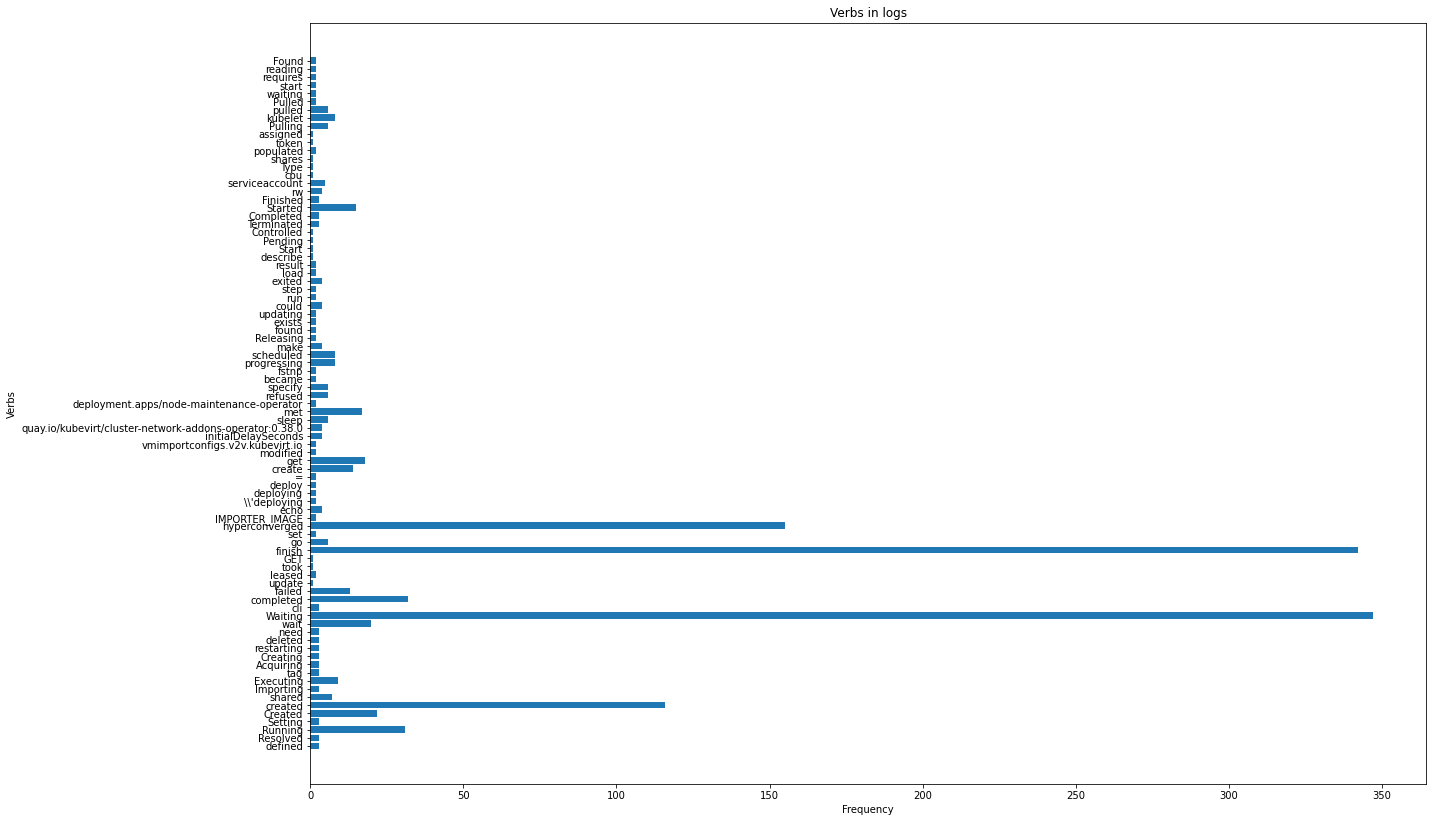

In [ ]:
# ******* NINGXIAO *******
# find events in log, display frequecy of each event in a bar chart
import spacy
s = ""
for log in array_of_logs2:
    temp = ""
    temp = temp.join(log)
    s += temp
# Error Message: Text of length 5496377 exceeds maximum of 1000000.
s = s[0:100000]
nlp = spacy.load("en_core_web_sm")
doc = nlp(s)
dictionary = {};
for token in doc:
    if token.pos_ == 'VERB':
        if token.text not in dictionary:
            dictionary[token.text] = 1
        else:
            dictionary[token.text] += 1
    #print(token.text, toekn.pos_)

#print(dictionary)

keys = list(dictionary.keys())
values = list(dictionary.values())

fig, ax = plt.subplots(figsize=(20, 14))  
ax.barh(keys,values)
plt.title('Verbs in logs')
plt.ylabel('Verbs')
plt.xlabel('Frequency')

plt.show()

The image above shows the verbs and their frequency appear in the tokenized log text. It indicates what event and how often it happens in the log.

***Analysis logs***

In [63]:
# ******* Tianze Shan *******

# input: dict of logs, wether show negative logs
# return: dict of log scores, negative logs if TRUE
def score_clusters(cluster_id, show_negative_logs=False):
  from textblob import TextBlob
  logList=[]
  for i in range(1,len(cluster_id)+1):
    valueList=[]
    for log in cluster_id[i]:
      emotionScore = TextBlob(log).sentiment.polarity
      if emotionScore < 0 and show_negative_logs==True:
        print('cluster_id =',i ,' includes log has negative score ', round(emotionScore,3),': ',log)
      valueList.append(emotionScore)
    logList.append(valueList)
    # print('emotion score of Cluster_id ',i,': ', valueList)
    scoreDict = dict(zip(list(range(1,len(cluster_id)+1)), logList))
  return scoreDict

# input: dict of logs, keyword
# return: dict of number of keyword in each log
def countWords(cluster_id, word):
  numFail=[]
  for i in range(1,len(cluster_id)+1):
    countList=[]
    for log in cluster_id[i]:
      count= log.lower().count(word)
      countList.append(count)
      # print('Cluster_id ',i,': ', count)
    numFail.append(countList)
    result = dict(zip(list(range(1,len(cluster_id)+1)), numFail))
  return result

In [64]:
#print failed logs (negative socres) and a dictionary of emotion score
# print(score_clusters(cluster_id,True))


In [ ]:
print('count fail: ', countWords(cluster_id,'fail'))
print('count timeout: ', countWords(cluster_id,'timeout'))
print('emotion score: ', score_clusters(cluster_id))

count fail:  {1: [9], 2: [8], 3: [8], 4: [8], 5: [8], 6: [8], 7: [8], 8: [8], 9: [8], 10: [8], 11: [8], 12: [8], 13: [8], 14: [8], 15: [8], 16: [8], 17: [8], 18: [8], 19: [8, 8], 20: [8], 21: [8], 22: [5], 23: [8], 24: [61], 25: [8], 26: [235], 27: [8], 28: [8], 29: [8], 30: [61], 31: [8], 32: [122], 33: [8], 34: [8], 35: [8], 36: [8], 37: [8], 38: [8], 39: [8], 40: [28], 41: [8], 42: [8], 43: [8], 44: [8], 45: [8], 46: [8], 47: [8], 48: [8], 49: [8], 50: [8], 51: [140], 52: [14], 53: [73], 54: [9], 55: [8], 56: [8], 57: [7], 58: [8], 59: [7], 60: [8], 61: [8], 62: [8], 63: [8], 64: [8], 65: [8], 66: [8], 67: [8], 68: [8], 69: [8], 70: [8], 71: [8], 72: [7], 73: [8], 74: [8], 75: [8], 76: [8], 77: [8], 78: [8], 79: [8], 80: [8], 81: [8], 82: [8], 83: [8], 84: [7], 85: [8], 86: [8], 87: [7], 88: [10], 89: [3], 90: [0], 91: [0], 92: [0], 93: [9], 94: [33], 95: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 96: [0], 97: [22], 98: [17], 99: [0, 0], 100: [0, 0, 0, 0, 0, 0, 0, 0], 101: [0, 0, 0, 0, 0], 102

In [ ]:
#{[1,1,1],[3,3],[1,2,3]} -> {[1],[3],[2]}
import numpy as np
def mean_dict(dic):
  mean_list=[]
  for key, value in dic.items():
    mean_list.append(np.mean(value))
  result = dict(zip(list(range(1,len(dic)+1)),mean_list))
  return result




In [ ]:
def dictDraw(dictionary,title,xlabel,ylabel):
  keys = list(dictionary.keys())
  values = list(dictionary.values())
  fig, ax = plt.subplots(figsize=(14, 7))  
  ax.barh(keys,values)
  plt.title(title)
  plt.ylabel(ylabel)
  plt.xlabel(xlabel)
  plt.show()

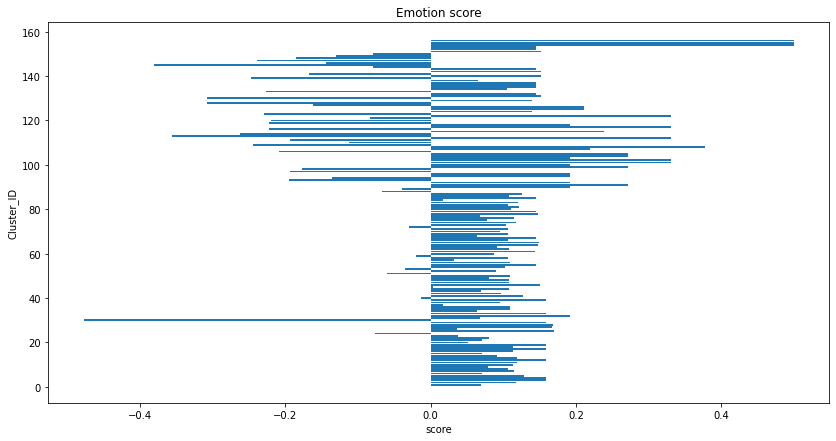

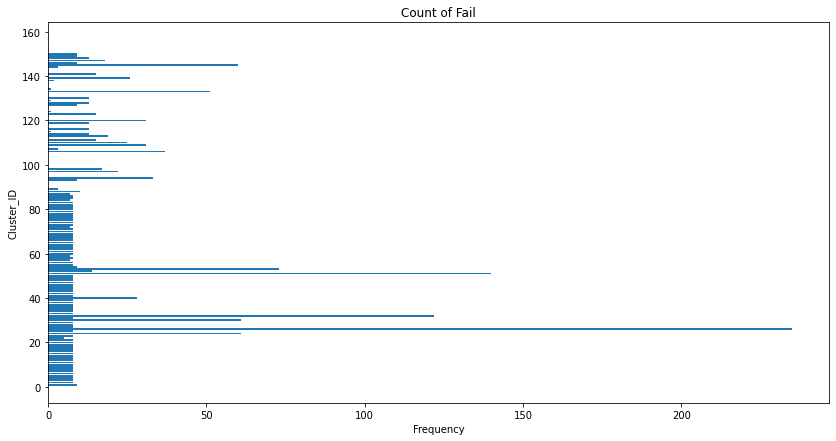

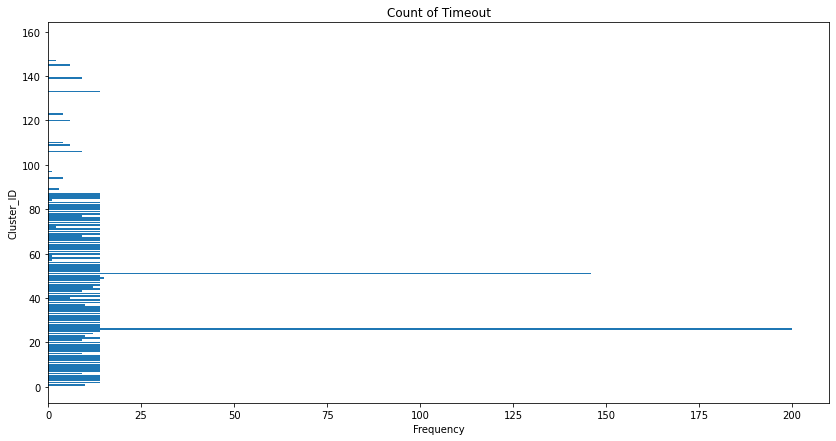

In [ ]:
# Distribution of negative score is similar to the distribution of amount of 'fail'. 
# This is reasonable since emotion score is based on sentiment analysis.
# Distribution of amount of 'Timeout' is less representative than the distribution of amount of 'fail'
# because timeout is the one of many reasons of fail. 
dictDraw(mean_dict(score_clusters(cluster_id)),'Emotion score','score','Cluster_ID')
dictDraw(mean_dict(countWords(cluster_id,'fail')),'Count of Fail','Frequency','Cluster_ID')
dictDraw(mean_dict(countWords(cluster_id,'timeout')),'Count of Timeout','Frequency','Cluster_ID')